# RevuNet Sentiment Upgrade — TextBlob, TF‑IDF and DistilBERT

_Exported: 2025-08-16T03:00:46.868222Z_


## What you'll get
- **TextBlob** baseline for quick polarity scoring.
- **TF‑IDF + Linear (SGD)** classifier training and evaluation (mirrors your `train_sentiment.py` flow).
- **DistilBERT** fine‑tuning with Hugging Face `transformers` + evaluation and export for inference.
- Unified inference helpers + star‑rating mapping and JSON outputs compatible with your API.


#0) Environment setup
> If you're running this on Colab or a fresh venv, run this once.


In [38]:
# If needed, uncomment to install deps.
# !pip -q install pandas scikit-learn textblob wordcloud matplotlib transformers datasets accelerate torch --upgrade

import os, re, json, math, random
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from textblob import TextBlob

# HF/transformers (used later)
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          DataCollatorWithPadding, TrainingArguments, Trainer)
import torch


## 1) Load data
Assumes a CSV with at least **`Review`** and **`Rating`** columns (like your current dataset).


In [41]:
DATA_PATH = 'trip_res_reviews.csv'  # adjust if needed
assert Path(DATA_PATH).exists(), f"CSV not found at {DATA_PATH}. Upload it here or change the path."

df = pd.read_csv(DATA_PATH)
expected_cols = {'Review','Rating'}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV must contain columns: {expected_cols}. Missing: {missing}")

# Basic clean
df = df.dropna(subset=['Review','Rating'])
df['Review'] = df['Review'].astype(str).str.strip()
df = df[df['Review']!='']

def rating_to_label(r):
    try:
        r = float(r)
    except:
        return None
    if r >= 4: return 'pos'
    if r <= 2: return 'neg'
    return 'neu'

df['label'] = df['Rating'].apply(rating_to_label)
df = df.dropna(subset=['label']).reset_index(drop=True)
print(df.head())
print(df['label'].value_counts())


        Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   
1  Ambience is too good for a pleasant evening. S...      5   
2  A must try.. great food great ambience. Thnx f...      5   
3  Soumen das and Arun was a great guy. Only beca...      5   
4  Food is good.we ordered Kodi drumsticks and ba...      5   

                  Metadata             Time  Pictures    7514 label  
0   1 Review , 2 Followers  5/25/2019 15:54         0  2447.0   pos  
1  3 Reviews , 2 Followers  5/25/2019 14:20         0     NaN   pos  
2  2 Reviews , 3 Followers  5/24/2019 22:54         0     NaN   pos  
3    1 Review , 1 Follower  5/24/2019 22:11         0     NaN   pos  
4  3 R

## 2) TextBlob baseline
We compute polarity for each review and turn it into **[-1, 1]** score and **star ratings [1..5]**.


In [43]:
def tb_score_to_label(score, pos_thr=0.2, neg_thr=-0.2):
    if score > pos_thr: return 'pos'
    if score < neg_thr: return 'neg'
    return 'neu'

def polarity_to_stars(p):
    # Map [-1..1] -> [1..5]
    stars = (p + 1) * 2.0  # 0..4 -> shift to 1..5 after clamp
    return float(np.clip(stars+1, 1.0, 5.0))

df['polarity'] = df['Review'].map(lambda t: TextBlob(t).sentiment.polarity)
df['tb_label'] = df['polarity'].map(tb_score_to_label)

acc_tb = accuracy_score(df['label'], df['tb_label'])
print(f"TextBlob baseline accuracy: {acc_tb:.4f}")
print(classification_report(df['label'], df['tb_label'], digits=4))


TextBlob baseline accuracy: 0.6594
              precision    recall  f1-score   support

         neg     0.8971    0.3769    0.5307      2428
         neu     0.1996    0.4928    0.2841      1258
         pos     0.8629    0.8023    0.8315      6268

    accuracy                         0.6594      9954
   macro avg     0.6532    0.5573    0.5488      9954
weighted avg     0.7874    0.6594    0.6890      9954



## 3) TF‑IDF + Linear (SGD) model
Replicates your script but within the notebook, and stores artifacts.


In [45]:
def simple_clean(s: str) -> str:
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

df['text_clean'] = df['Review'].map(simple_clean)
X_train, X_val, y_train, y_val = train_test_split(
    df['text_clean'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=2)
X_train_vec = tfidf.fit_transform(X_train)

clf = SGDClassifier(loss='log_loss', max_iter=20, random_state=42)
clf.fit(X_train_vec, y_train)

pred = clf.predict(tfidf.transform(X_val))
acc = accuracy_score(y_val, pred)
print(f"TF-IDF + Linear accuracy: {acc:.4f}")
print(classification_report(y_val, pred, digits=4))

# Save artifacts
OUT_DIR = Path('models/tfidf_sgd')
OUT_DIR.mkdir(parents=True, exist_ok=True)

import joblib, json as _json, datetime as _dt
joblib.dump(tfidf, OUT_DIR/'sa_tfidf.joblib')
joblib.dump(clf, OUT_DIR/'sa_lr.joblib')
with open(OUT_DIR/'model_card.json','w') as f:
    _json.dump({
        "model_name": "Linear (SGD log-loss) + TF-IDF",
        "version": "1.1.0",
        "timestamp": _dt.datetime.now(_dt.timezone.utc).isoformat().replace("+00:00", "Z"),
        "metrics": {"val_accuracy": float(acc)},
        "label_set": ["neg","neu","pos"]
    }, f, indent=2)

print("Artifacts saved to:", OUT_DIR)


TF-IDF + Linear accuracy: 0.8383
              precision    recall  f1-score   support

         neg     0.8093    0.8560    0.8320       486
         neu     0.5301    0.1753    0.2635       251
         pos     0.8673    0.9641    0.9131      1254

    accuracy                         0.8383      1991
   macro avg     0.7356    0.6651    0.6695      1991
weighted avg     0.8106    0.8383    0.8114      1991

Artifacts saved to: models/tfidf_sgd


## 4) DistilBERT fine‑tuning
Quick, compact Transformer that usually outperforms TF‑IDF on enough data.


In [ ]:
# ===== DistilBERT fine-tuning (NO Trainer, NO accelerate, NO widgets) =====
import os, math, random, numpy as np, torch
from dataclasses import dataclass
from typing import List, Tuple
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ------------------------------------------------------------------
# Quiet any widget/logging noise & make runs reproducible
# ------------------------------------------------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"
os.environ["DISABLE_TQDM"] = "1"  # silence notebook progress widgets

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ------------------------------------------------------------------
# Label mappings (keep consistent across training & inference)
# ------------------------------------------------------------------
label2id = {'neg': 0, 'neu': 1, 'pos': 2}
id2label = {v: k for k, v in label2id.items()}

# ------------------------------------------------------------------
# Expect an existing `df` DataFrame with columns: Review (str), label in {'neg','neu','pos'}
# If not present, raise a helpful error.
# ------------------------------------------------------------------
try:
    _ = df[['Review', 'label']]
except Exception as e:
    raise RuntimeError("Expected a pandas DataFrame named `df` with columns ['Review','label'].") from e

train_df, val_df = train_test_split(
    df[['Review', 'label']], test_size=0.2, random_state=42, stratify=df['label']
)

# ------------------------------------------------------------------
# Tokenizer & Model
# NOTE: You will *always* see a one-time info about newly initialized
# classifier weights. That's expected (new classification head).
# ------------------------------------------------------------------
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, id2label=id2label, label2id=label2id
)

# ------------------------------------------------------------------
# Encode -> TensorDataset
# ------------------------------------------------------------------
def encode_to_tensor_dataset(df_part) -> TensorDataset:
    enc = tokenizer(
        df_part['Review'].tolist(),
        truncation=True,
        padding=True,
        return_tensors='pt'
    )
    labels = torch.tensor([label2id[y] for y in df_part['label']], dtype=torch.long)
    return TensorDataset(enc['input_ids'], enc['attention_mask'], labels)

train_ds = encode_to_tensor_dataset(train_df)
val_ds   = encode_to_tensor_dataset(val_df)

# ------------------------------------------------------------------
# DataLoaders (keep conservative for CPU)
# ------------------------------------------------------------------
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False)

# ------------------------------------------------------------------
# Device (CUDA > MPS > CPU)
# ------------------------------------------------------------------
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    ("mps" if torch.backends.mps.is_available() else "cpu")
)
model.to(device)

# Avoid thread oversubscription on CPU-only boxes
try:
    torch.set_num_threads(max(1, os.cpu_count() // 2))
except Exception:
    pass

# ------------------------------------------------------------------
# Optimizer / (optional) scheduler
# ------------------------------------------------------------------
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 2
num_train_steps = num_epochs * max(1, len(train_loader))
# Simple linear-decay scheduler (optional but nice)
from torch.optim.lr_scheduler import LambdaLR
lr_lambda = lambda step: 1 - step / max(1, num_train_steps)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# Enable mixed-precision on CUDA only (safe & faster). Skip on MPS/CPU.
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# ------------------------------------------------------------------
# Training loop
# ------------------------------------------------------------------
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (input_ids, attn, y) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attn      = attn.to(device)
        y         = y.to(device)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.cuda.amp.autocast():
                out = model(input_ids=input_ids, attention_mask=attn, labels=y)
                loss = out.loss
            scaler.scale(loss).backward()
            # Gradient clipping for stability
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(input_ids=input_ids, attention_mask=attn, labels=y)
            loss = out.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        scheduler.step()
        total_loss += loss.item()

        # Optional: occasional loss print for sanity on first epoch
        if epoch == 0 and (batch_idx % 50 == 0):
            print(f"[e{epoch+1}] step {batch_idx}/{len(train_loader)} - loss={loss.item():.4f}")

    avg_loss = total_loss / max(1, len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {avg_loss:.4f}")

# ------------------------------------------------------------------
# Evaluation
# ------------------------------------------------------------------
model.eval()
preds, refs = [], []
with torch.no_grad():
    for input_ids, attn, y in val_loader:
        input_ids = input_ids.to(device)
        attn      = attn.to(device)
        logits = model(input_ids=input_ids, attention_mask=attn).logits
        pred = torch.argmax(logits, dim=-1).cpu().numpy().tolist()
        preds.extend(pred)
        refs.extend(y.numpy().tolist())

acc = accuracy_score(refs, preds)
print("Validation accuracy:", acc)
print(classification_report(refs, preds, labels=[0,1,2], target_names=['neg','neu','pos']))

# ------------------------------------------------------------------
# Save artifacts for inference
# ------------------------------------------------------------------
out_dir = "models/bert_sentiment"
os.makedirs(out_dir, exist_ok=True)
model.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)
print("Saved model + tokenizer to", out_dir)

# ------------------------------------------------------------------
# (Optional) quick inference helper to sanity-check the saved model
# ------------------------------------------------------------------
def bert_infer(texts: List[str], model_dir: str = "models/bert_sentiment"):
    tok = AutoTokenizer.from_pretrained(model_dir)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir)
    mdl.eval()
    with torch.no_grad():
        enc = tok(texts, truncation=True, padding=True, return_tensors='pt')
        probs = torch.softmax(mdl(**enc).logits, dim=-1).cpu().numpy()
    id2label_local = {0:'neg', 1:'neu', 2:'pos'}
    out = []
    for t, pr in zip(texts, probs):
        p_neg, p_neu, p_pos = pr.tolist()
        label = id2label_local[int(np.argmax(pr))]
        stars = float(np.clip((p_pos - p_neg + 1) * 2.0 + 1, 1.0, 5.0))  # map [-1..1] -> [1..5]
        out.append({
            "review_text": t,
            "sentiment_score": float(p_pos - p_neg),
            "sentiment_category": {"neg":"Negative","neu":"Neutral","pos":"Positive"}[label],
            "probs": {"neg": float(p_neg), "neu": float(p_neu), "pos": float(p_pos)},
            "stars": stars
        })
    return out

print(bert_infer([
    "Amazing service and spotless rooms!",
    "It was okay, not great, not bad.",
    "Awful experience, would not recommend."
]))


## 5) Inference helpers
Unified JSON output similar to your API needs; includes star mapping and average scores.


In [ ]:
import joblib, torch, numpy as np

def stars_from_probs(p_neg, p_neu, p_pos):
    # map (p_pos - p_neg) to stars
    score = float(p_pos - p_neg)  # [-1,1]
    return float(np.clip((score + 1) * 2.0 + 1, 1.0, 5.0))

def bert_infer(texts, model_dir='models/bert_sentiment'):
    tok = AutoTokenizer.from_pretrained(model_dir)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir)
    mdl.eval()
    with torch.no_grad():
        enc = tok(texts, truncation=True, padding=True, return_tensors='pt')
        logits = mdl(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    results = []
    for t, pr in zip(texts, probs):
        p_neg, p_neu, p_pos = pr.tolist()
        label = ['neg','neu','pos'][int(np.argmax(pr))]
        score = float(p_pos - p_neg)  # [-1,1]
        results.append({
            'review_text': t,
            'sentiment_score': score,
            'sentiment_category': {'neg':'Negative','neu':'Neutral','pos':'Positive'}[label],
            'probs': {'neg': p_neg, 'neu': p_neu, 'pos': p_pos},
            'stars': stars_from_probs(p_neg, p_neu, p_pos)
        })
    avg_score = float(np.mean([r['sentiment_score'] for r in results]))
    avg_stars = float(np.mean([r['stars'] for r in results]))
    return {
        'average_sentiment': avg_score,
        'avg_star_count': avg_stars,
        'sentiment_category_group': dict(pd.Series([r['sentiment_category'] for r in results]).value_counts()),
        'detailed_sentiments': results
    }

def tfidf_infer(texts, model_dir='models/tfidf_sgd'):
    tfidf = joblib.load(Path(model_dir)/'sa_tfidf.joblib')
    clf = joblib.load(Path(model_dir)/'sa_lr.joblib')
    probs = clf.predict_proba(tfidf.transform([re.sub(r"\s+"," ", t).strip().lower() for t in texts]))
    labels = clf.classes_.tolist()  # ['neg','neu','pos']
    idx = {l:i for i,l in enumerate(labels)}
    res = []
    for t, pr in zip(texts, probs):
        p_neg, p_neu, p_pos = pr[idx['neg']], pr[idx['neu']], pr[idx['pos']]
        label = labels[int(np.argmax(pr))]
        score = float(p_pos - p_neg)
        res.append({
            'review_text': t,
            'sentiment_score': score,
            'sentiment_category': {'neg':'Negative','neu':'Neutral','pos':'Positive'}[label],
            'probs': {'neg': float(p_neg), 'neu': float(p_neu), 'pos': float(p_pos)},
            'stars': stars_from_probs(p_neg, p_neu, p_pos)
        })
    return {
        'average_sentiment': float(np.mean([r['sentiment_score'] for r in res])),
        'avg_star_count': float(np.mean([r['stars'] for r in res])),
        'sentiment_category_group': dict(pd.Series([r['sentiment_category'] for r in res]).value_counts()),
        'detailed_sentiments': res
    }

def textblob_infer(texts, pos_thr=0.2, neg_thr=-0.2):
    res = []
    for t in texts:
        pol = TextBlob(t).sentiment.polarity
        lab = 'Positive' if pol>pos_thr else 'Negative' if pol<neg_thr else 'Neutral'
        stars = (pol + 1) * 2.0 + 1
        res.append({
            'review_text': t,
            'sentiment_score': float(pol),
            'sentiment_category': lab,
            'stars': float(np.clip(stars,1.0,5.0))
        })
    return {
        'average_sentiment': float(np.mean([r['sentiment_score'] for r in res])),
        'avg_star_count': float(np.mean([r['stars'] for r in res])),
        'sentiment_category_group': dict(pd.Series([r['sentiment_category'] for r in res]).value_counts()),
        'detailed_sentiments': res
    }


## 6) Quick smoke test


In [10]:
def textblob_infer(texts, pos_thr=0.2, neg_thr=-0.2):
    res = []
    for t in texts:
        pol = TextBlob(t).sentiment.polarity
        lab = 'Positive' if pol>pos_thr else 'Negative' if pol<neg_thr else 'Neutral'
        stars = (pol + 1) * 2.0 + 1
        res.append({
            'review_text': str(t),
            'sentiment_score': float(pol),
            'sentiment_category': lab,
            'stars': float(np.clip(stars, 1.0, 5.0))
        })
    out = {
        'average_sentiment': float(np.mean([r['sentiment_score'] for r in res])) if res else 0.0,
        'avg_star_count': float(np.mean([r['stars'] for r in res])) if res else 0.0,
        'sentiment_category_group': {k:int(v) for k,v in pd.Series([r['sentiment_category'] for r in res]).value_counts().to_dict().items()},
        'detailed_sentiments': res
    }
    return to_py(out)

def tfidf_infer(texts, model_dir='models/tfidf_sgd'):
    tfidf = joblib.load(Path(model_dir)/'sa_tfidf.joblib')
    clf = joblib.load(Path(model_dir)/'sa_lr.joblib')
    probs = clf.predict_proba(tfidf.transform([re.sub(r"\s+"," ", t).strip().lower() for t in texts]))
    labels = clf.classes_.tolist()
    idx = {l:i for i,l in enumerate(labels)}
    detailed = []
    for t, pr in zip(texts, probs):
        p_neg, p_neu, p_pos = float(pr[idx['neg']]), float(pr[idx['neu']]), float(pr[idx['pos']])
        label = labels[int(np.argmax(pr))]
        detailed.append({
            'review_text': str(t),
            'sentiment_score': float(p_pos - p_neg),
            'sentiment_category': {'neg':'Negative','neu':'Neutral','pos':'Positive'}[label],
            'probs': {'neg': p_neg, 'neu': p_neu, 'pos': p_pos},
            'stars': float(np.clip((p_pos - p_neg + 1) * 2.0 + 1, 1.0, 5.0))
        })
    out = {
        'average_sentiment': float(np.mean([d['sentiment_score'] for d in detailed])) if detailed else 0.0,
        'avg_star_count': float(np.mean([d['stars'] for d in detailed])) if detailed else 0.0,
        'sentiment_category_group': {k:int(v) for k,v in pd.Series([d['sentiment_category'] for d in detailed]).value_counts().to_dict().items()},
        'detailed_sentiments': detailed
    }
    return to_py(out)

def bert_infer(texts, model_dir='models/bert_sentiment'):
    tok = AutoTokenizer.from_pretrained(model_dir)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir)
    mdl.eval()
    with torch.no_grad():
        enc = tok(texts, truncation=True, padding=True, return_tensors='pt')
        logits = mdl(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    res = []
    for t, pr in zip(texts, probs):
        p_neg, p_neu, p_pos = (float(pr[0]), float(pr[1]), float(pr[2]))
        label = ['neg','neu','pos'][int(np.argmax(pr))]
        res.append({
            'review_text': str(t),
            'sentiment_score': float(p_pos - p_neg),
            'sentiment_category': {'neg':'Negative','neu':'Neutral','pos':'Positive'}[label],
            'probs': {'neg': p_neg, 'neu': p_neu, 'pos': p_pos},
            'stars': float(np.clip((p_pos - p_neg + 1) * 2.0 + 1, 1.0, 5.0))
        })
    out = {
        'average_sentiment': float(np.mean([r['sentiment_score'] for r in res])) if res else 0.0,
        'avg_star_count': float(np.mean([r['stars'] for r in res])) if res else 0.0,
        'sentiment_category_group': {k:int(v) for k,v in pd.Series([r['sentiment_category'] for r in res]).value_counts().to_dict().items()},
        'detailed_sentiments': res
    }
    return to_py(out)


In [11]:
# --- drop this helper once, near your imports ---
import numpy as np
import pandas as pd
import json
import re
import joblib
from pathlib import Path
from textblob import TextBlob

# HuggingFace
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

def to_py(x):
    """Recursively convert NumPy scalars/arrays to plain Python types."""
    if isinstance(x, dict):
        return {to_py(k): to_py(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [to_py(v) for v in x]
    if isinstance(x, (np.integer,)):
        return int(x)
    if isinstance(x, (np.floating,)):
        return float(x)
    if isinstance(x, (np.bool_,)):
        return bool(x)
    if isinstance(x, np.ndarray):
        return x.tolist()
    return x



sample_texts = [
    "Staff were super friendly and the room was spotless.",
    "Mediocre coffee. Nothing special but not terrible.",
    "Terrible service; waited 45 minutes and got the wrong order."
]

print("TEXTBLOB ->", json.dumps(to_py(textblob_infer(sample_texts)), indent=2)[:500], "...\n")
print("TFIDF    ->", json.dumps(to_py(tfidf_infer(sample_texts)), indent=2)[:500], "...\n")
print("BERT     ->", json.dumps(to_py(bert_infer(sample_texts)), indent=2)[:500], "...\n")



TEXTBLOB -> {
  "average_sentiment": -0.09226190476190477,
  "avg_star_count": 2.8154761904761902,
  "sentiment_category_group": {
    "Positive": 1,
    "Neutral": 1,
    "Negative": 1
  },
  "detailed_sentiments": [
    {
      "review_text": "Staff were super friendly and the room was spotless.",
      "sentiment_score": 0.35416666666666663,
      "sentiment_category": "Positive",
      "stars": 3.708333333333333
    },
    {
      "review_text": "Mediocre coffee. Nothing special but not terrible.",
     ...

TFIDF    -> {
  "average_sentiment": -0.026143965093357036,
  "avg_star_count": 2.9477120698132864,
  "sentiment_category_group": {
    "Positive": 1,
    "Neutral": 1,
    "Negative": 1
  },
  "detailed_sentiments": [
    {
      "review_text": "Staff were super friendly and the room was spotless.",
      "sentiment_score": 0.7825988129139894,
      "sentiment_category": "Positive",
      "probs": {
        "neg": 0.08940199660233304,
        "neu": 0.03859719388134447,
      

In [13]:
# --- PREP DATAFRAME `df` ---
import os, pandas as pd

DATA_PATH = "trip_res_reviews.csv"

if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH).dropna(subset=["Review","Rating"]).copy()
    df["Review"] = df["Review"].astype(str).str.strip()
    df = df[df["Review"] != ""]
    
    # Try to coerce Rating to numeric; invalid strings become NaN
    df["Rating_num"] = pd.to_numeric(df["Rating"], errors="coerce")
    df = df.dropna(subset=["Rating_num"]).reset_index(drop=True)

    # Map numeric ratings to labels
    def rating_to_label(r):
        r = float(r)
        if r >= 4: return "pos"
        if r <= 2: return "neg"
        return "neu"

    df["label"] = df["Rating_num"].apply(rating_to_label)
    print(f"Loaded {len(df)} rows from {DATA_PATH}")
    print(df["label"].value_counts())
else:
    # Fallback demo
    print(f"[WARN] {DATA_PATH} not found. Using a demo dataset.")
    demo = {
        "Review": [
            "Amazing staff and spotless room.",
            "It was okay, nothing special.",
            "Terrible service and long wait."
        ],
        "Rating": [5, 3, 1]
    }
    df = pd.DataFrame(demo)
    def rating_to_label(r):
        if r >= 4: return "pos"
        if r <= 2: return "neg"
        return "neu"
    df["label"] = df["Rating"].apply(rating_to_label)
    print(df)


Loaded 9954 rows from trip_res_reviews.csv
label
pos    6268
neg    2428
neu    1258
Name: count, dtype: int64


In [ ]:
# === Full evaluation cell: TextBlob vs TF-IDF vs DistilBERT ===
%matplotlib inline
import re, os, json, joblib, torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# If you see "No module named transformers", install it (and datasets/torch if missing)
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ---------- 0) Preconditions ----------
assert 'df' in globals(), "Expected a DataFrame `df` in memory."
assert {'Review','label'}.issubset(df.columns), "df must have columns: Review, label"

LABELS = ['neg','neu','pos']
LABEL_TO_READABLE = {'neg':'Negative','neu':'Neutral','pos':'Positive'}

# Data split (seeded for reproducibility)
X_train, X_val, y_train, y_val = train_test_split(
    df['Review'].astype(str),
    df['label'],
    test_size=0.20,
    random_state=42,
    stratify=df['label']
)

# ---------- 1) Predictors ----------
def predict_textblob(texts, pos_thr=0.20, neg_thr=-0.20):
    out = []
    for t in texts:
        p = TextBlob(t).sentiment.polarity
        if p > pos_thr: out.append('pos')
        elif p < neg_thr: out.append('neg')
        else: out.append('neu')
    return out

def predict_tfidf(texts, model_dir="models/tfidf_sgd"):
    vec_path = Path(model_dir)/"sa_tfidf.joblib"
    clf_path = Path(model_dir)/"sa_lr.joblib"
    if not vec_path.exists() or not clf_path.exists():
        raise FileNotFoundError(f"Missing TF-IDF artifacts in {model_dir} (expected sa_tfidf.joblib and sa_lr.joblib)")
    vec = joblib.load(vec_path)
    clf = joblib.load(clf_path)
    X = vec.transform([re.sub(r"\s+"," ", t).strip().lower() for t in texts])
    return clf.predict(X).tolist()  # labels like 'neg','neu','pos'

def predict_bert(texts, model_dir="models/bert_sentiment"):
    model_dir = Path(model_dir)
    if not (model_dir/"config.json").exists():
        raise FileNotFoundError(f"Missing BERT artifacts in {model_dir} (expected config.json + model weights)")
    tok = AutoTokenizer.from_pretrained(model_dir.as_posix())
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir.as_posix())
    mdl.eval()
    with torch.no_grad():
        enc = tok(list(map(str, texts)), truncation=True, padding=True, return_tensors='pt')
        logits = mdl(**enc).logits
        preds = logits.argmax(dim=-1).cpu().numpy()
    id2label = {0:'neg',1:'neu',2:'pos'}
    return [id2label[int(i)] for i in preds]

# ---------- 2) Evaluator ----------
def evaluate(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, labels=LABELS, average='macro')
    cm  = confusion_matrix(y_true, y_pred, labels=LABELS)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Macro F1: {f1m:.4f}")
    print("Classification report:")
    print(classification_report(y_true, y_pred, labels=LABELS, target_names=LABELS, digits=4))
    return {"name": name, "accuracy": acc, "macro_f1": f1m, "cm": cm}

# ---------- 3) Run all models (gracefully skip missing ones) ----------
results = []
mats = []  # (title, cm)

# TextBlob (always available)
pred_tb = predict_textblob(X_val)
m_tb = evaluate("TextBlob", y_val, pred_tb)
results.append(m_tb); mats.append(("TextBlob", m_tb["cm"]))

# TF-IDF (if artifacts exist)
try:
    pred_tfidf = predict_tfidf(X_val, "models/tfidf_sgd")
    m_tf = evaluate("TF-IDF (Linear)", y_val, pred_tfidf)
    results.append(m_tf); mats.append(("TF-IDF (Linear)", m_tf["cm"]))
except Exception as e:
    print(f"\n[WARN] Skipping TF-IDF: {e}")

# BERT (if artifacts exist)
try:
    pred_bert = predict_bert(X_val, "models/bert_sentiment")
    m_be = evaluate("DistilBERT", y_val, pred_bert)
    results.append(m_be); mats.append(("DistilBERT", m_be["cm"]))
except Exception as e:
    print(f"\n[WARN] Skipping BERT: {e}")

# ---------- 4) Summary + Best model ----------
if results:
    summary_df = pd.DataFrame([
        {"Model": r["name"], "Accuracy": r["accuracy"], "Macro F1": r["macro_f1"]}
        for r in results
    ]).sort_values(by=["Macro F1","Accuracy"], ascending=False)
    print("\n=== Summary (sorted by Macro F1, then Accuracy) ===")
    print(summary_df.to_string(index=False))
    best = summary_df.iloc[0]["Model"]
    print(f"\n>>> BEST MODEL: {best} <<<")
else:
    print("\n[ERROR] No models were evaluated. Check that df is set and model artifacts exist.")

# ---------- 5) Confusion matrices: inline + saved PNGs ----------
if mats:
    cols = len(mats)
    fig, axes = plt.subplots(1, cols, figsize=(6*cols, 5))
    if cols == 1:
        axes = [axes]
    for ax, (title, cm) in zip(axes, mats):
        im = ax.imshow(cm, cmap="Blues")
        ax.set_title(title)
        ax.set_xlabel("Predicted"); ax.set_ylabel("True")
        ax.set_xticks(range(len(LABELS))); ax.set_xticklabels(LABELS)
        ax.set_yticks(range(len(LABELS))); ax.set_yticklabels(LABELS)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
    fig.colorbar(im, ax=axes, shrink=0.8)
    plt.tight_layout()
    plt.show()

    # Save each matrix to PNG
    for title, cm in mats:
        plt.figure(figsize=(4.5,4.5))
        plt.imshow(cm, cmap="Blues")
        plt.title(f"{title} Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.xticks(range(len(LABELS)), LABELS)
        plt.yticks(range(len(LABELS)), LABELS)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
        plt.colorbar()
        plt.tight_layout()
        fn = f"cm_{title.lower().replace(' ', '_').replace('(', '').replace(')', '')}.png"
        plt.savefig(fn, dpi=150)
        plt.close()
        print(f"[saved] {fn}")



=== TextBlob ===
Accuracy: 0.6650 | Macro F1: 0.5577
Classification report:
              precision    recall  f1-score   support

         neg     0.9078    0.3848    0.5405       486
         neu     0.2089    0.5219    0.2984       251
         pos     0.8687    0.8022    0.8342      1254

    accuracy                         0.6650      1991
   macro avg     0.6618    0.5696    0.5577      1991
weighted avg     0.7951    0.6650    0.6949      1991


=== TF-IDF (Linear) ===
Accuracy: 0.8383 | Macro F1: 0.6695
Classification report:
              precision    recall  f1-score   support

         neg     0.8093    0.8560    0.8320       486
         neu     0.5301    0.1753    0.2635       251
         pos     0.8673    0.9641    0.9131      1254

    accuracy                         0.8383      1991
   macro avg     0.7356    0.6651    0.6695      1991
weighted avg     0.8106    0.8383    0.8114      1991




=== TextBlob ===
Accuracy: 0.6650 | Macro F1: 0.5577
              precision    recall  f1-score   support

         neg     0.9078    0.3848    0.5405       486
         neu     0.2089    0.5219    0.2984       251
         pos     0.8687    0.8022    0.8342      1254

    accuracy                         0.6650      1991
   macro avg     0.6618    0.5696    0.5577      1991
weighted avg     0.7951    0.6650    0.6949      1991



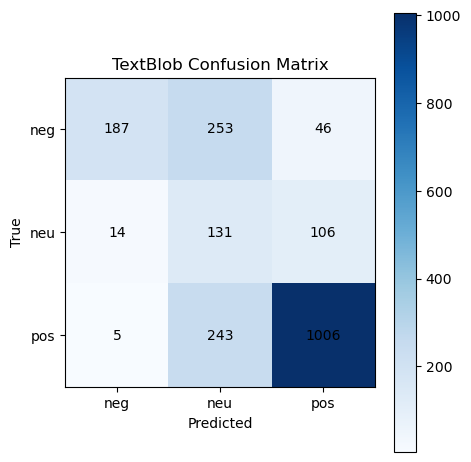

[saved] cm_textblob.png


In [10]:
# === TextBlob: Confusion Matrix + Metrics (saves cm_textblob.png) ===
%matplotlib inline
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

DATA_PATH = "trip_res_reviews.csv"
LABELS = ['neg','neu','pos']

# 0) Load/prepare df if needed
if 'df' not in globals():
    assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}"
    df = pd.read_csv(DATA_PATH).dropna(subset=["Review","Rating"]).copy()
    df["Review"] = df["Review"].astype(str).str.strip()
    df = df[df["Review"] != ""]
    df["Rating_num"] = pd.to_numeric(df["Rating"], errors="coerce")
    df = df.dropna(subset=["Rating_num"]).reset_index(drop=True)
    def rating_to_label(r):
        r = float(r)
        if r >= 4: return "pos"
        if r <= 2: return "neg"
        return "neu"
    df["label"] = df["Rating_num"].apply(rating_to_label)

# 1) Split (seeded)
X_train, X_val, y_train, y_val = train_test_split(
    df["Review"].astype(str), df["label"],
    test_size=0.20, random_state=42, stratify=df["label"]
)

# 2) Predict
def predict_textblob(texts, pos_thr=0.20, neg_thr=-0.20):
    out = []
    for t in texts:
        p = TextBlob(str(t)).sentiment.polarity
        out.append('pos' if p>pos_thr else 'neg' if p<neg_thr else 'neu')
    return out

pred = predict_textblob(X_val)

# 3) Metrics + Confusion Matrix
acc = accuracy_score(y_val, pred)
f1m = f1_score(y_val, pred, labels=LABELS, average='macro')
cm  = confusion_matrix(y_val, pred, labels=LABELS)
print("\n=== TextBlob ===")
print(f"Accuracy: {acc:.4f} | Macro F1: {f1m:.4f}")
print(classification_report(y_val, pred, labels=LABELS, target_names=LABELS, digits=4))

plt.figure(figsize=(4.8,4.8))
plt.imshow(cm, cmap="Blues")
plt.title("TextBlob Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(LABELS)), LABELS); plt.yticks(range(len(LABELS)), LABELS)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
plt.colorbar(); plt.tight_layout(); plt.show()

# Save PNG
plt.figure(figsize=(4.8,4.8))
plt.imshow(cm, cmap="Blues")
plt.title("TextBlob Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(LABELS)), LABELS); plt.yticks(range(len(LABELS)), LABELS)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
plt.colorbar(); plt.tight_layout()
plt.savefig("cm_textblob.png", dpi=150); plt.close()
print("[saved] cm_textblob.png")


[INFO] Using existing TF-IDF artifacts.

=== TF-IDF (Linear, balanced) ===
Accuracy: 0.6298 | Macro F1: 0.2576
              precision    recall  f1-score   support

         neg     0.0000    0.0000    0.0000       486
         neu     0.0000    0.0000    0.0000       251
         pos     0.6298    1.0000    0.7729      1254

    accuracy                         0.6298      1991
   macro avg     0.2099    0.3333    0.2576      1991
weighted avg     0.3967    0.6298    0.4868      1991



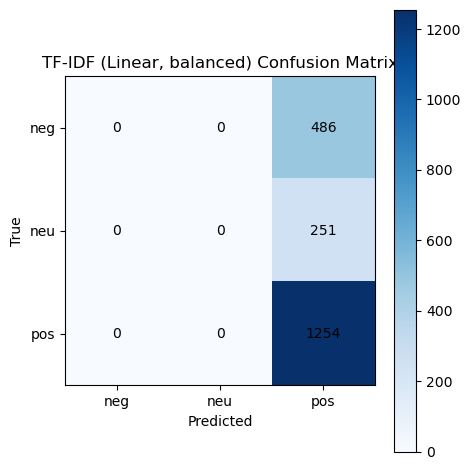

[saved] cm_tfidf_linear.png


In [16]:
# === TF-IDF (Linear): Balanced + Confusion Matrix (cm_tfidf_linear.png) ===
%matplotlib inline
import os, re, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

DATA_PATH = "trip_res_reviews.csv"
ART_DIR = Path("models/tfidf_sgd"); ART_DIR.mkdir(parents=True, exist_ok=True)
VEC_PATH = ART_DIR/"sa_tfidf.joblib"
CLF_PATH = ART_DIR/"sa_lr.joblib"   # keeping name for backward compatibility
LABELS = ['neg','neu','pos']

# Load df if needed
if 'df' not in globals():
    assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}"
    df = pd.read_csv(DATA_PATH).dropna(subset=["Review","Rating"]).copy()
    df["Review"] = df["Review"].astype(str).str.strip()
    df = df[df["Review"] != ""]
    df["Rating_num"] = pd.to_numeric(df["Rating"], errors="coerce")
    df = df.dropna(subset=["Rating_num"]).reset_index(drop=True)
    def rating_to_label(r):
        r = float(r)
        if r >= 4: return "pos"
        if r <= 2: return "neg"
        return "neu"
    df["label"] = df["Rating_num"].apply(rating_to_label)

X_train, X_val, y_train, y_val = train_test_split(
    df["Review"].astype(str), df["label"], test_size=0.20, random_state=42, stratify=df["label"]
)

def _clean(s: str) -> str:
    s = re.sub(r"http\\S+", " ", s)
    s = re.sub(r"[^\\w\\s]", " ", s)
    s = re.sub(r"\\s+", " ", s).strip().lower()
    return s

# Train (or reuse) artifacts
if not (VEC_PATH.exists() and CLF_PATH.exists()):
    print("[INFO] Training TF-IDF + LogisticRegression(class_weight='balanced') ...")
    tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=3000, min_df=2)
    X_tr_vec = tfidf.fit_transform(X_train.map(_clean))

    # Balanced LR (handles class imbalance better than plain SGD)
    clf = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        n_jobs=None,  # set to -1 if scikit-learn version allows for LR
        multi_class="auto"
    )
    clf.fit(X_tr_vec, y_train)

    joblib.dump(tfidf, VEC_PATH); joblib.dump(clf, CLF_PATH)
    print(f"[saved] {VEC_PATH}\n[saved] {CLF_PATH}")
else:
    print("[INFO] Using existing TF-IDF artifacts.")
    tfidf = joblib.load(VEC_PATH); clf = joblib.load(CLF_PATH)

# Predict
X_val_vec = tfidf.transform(X_val.map(_clean))
pred = clf.predict(X_val_vec)

# Metrics
acc = accuracy_score(y_val, pred)
f1m = f1_score(y_val, pred, labels=LABELS, average='macro', zero_division=0)
cm  = confusion_matrix(y_val, pred, labels=LABELS)
print("\n=== TF-IDF (Linear, balanced) ===")
print(f"Accuracy: {acc:.4f} | Macro F1: {f1m:.4f}")
print(classification_report(y_val, pred, labels=LABELS, target_names=LABELS, digits=4, zero_division=0))

# Confusion matrix
plt.figure(figsize=(4.8,4.8))
plt.imshow(cm, cmap="Blues")
plt.title("TF-IDF (Linear, balanced) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(LABELS)), LABELS); plt.yticks(range(len(LABELS)), LABELS)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
plt.colorbar(); plt.tight_layout(); plt.show()

# Save PNG
plt.figure(figsize=(4.8,4.8))
plt.imshow(cm, cmap="Blues")
plt.title("TF-IDF (Linear, balanced) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(LABELS)), LABELS); plt.yticks(range(len(LABELS)), LABELS)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
plt.colorbar(); plt.tight_layout()
plt.savefig("cm_tfidf_linear.png", dpi=150); plt.close()
print("[saved] cm_tfidf_linear.png")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Found saved BERT. Loading weights...

=== DistilBERT ===
Accuracy: 0.8699 | Macro F1: 0.7595
Classification report:
              precision    recall  f1-score   support

         neg     0.8555    0.9012    0.8778       486
         neu     0.5397    0.4064    0.4636       251
         pos     0.9240    0.9506    0.9371      1254

    accuracy                         0.8699      1991
   macro avg     0.7731    0.7527    0.7595      1991
weighted avg     0.8588    0.8699    0.8629      1991



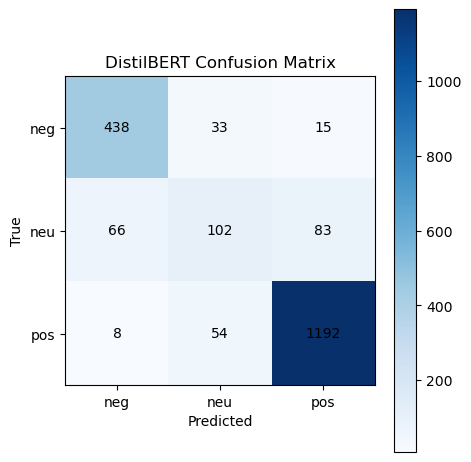

[saved] cm_distilbert.png


In [20]:
# === DistilBERT: Train-if-needed + Batched CPU Inference + Confusion Matrix (cm_distilbert.png) ===
%matplotlib inline
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, re
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

# ------------------ CONFIG ------------------
DATA_PATH = "trip_res_reviews.csv"          # change if your CSV lives elsewhere
BERT_DIR  = Path("models/bert_sentiment")   # where model/tokenizer will be saved/loaded
BERT_DIR.mkdir(parents=True, exist_ok=True)
LABELS    = ['neg','neu','pos']
EPOCHS    = 2
TRAIN_BS  = 8
VAL_BS    = 16
INF_BS    = 16          # inference batch size (smaller => safer)
INF_MAXLEN= 256         # inference max tokens (smaller => safer)
USE_CPU_INFERENCE = True  # force inference on CPU to avoid MPS/GPU OOMs

# ------------------ DATA LOAD / CLEAN ------------------
if 'df' not in globals():
    assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}"
    df = pd.read_csv(DATA_PATH).dropna(subset=["Review","Rating"]).copy()
    df["Review"] = df["Review"].astype(str).str.strip()
    df = df[df["Review"] != ""]
    df["Rating_num"] = pd.to_numeric(df["Rating"], errors="coerce")
    df = df.dropna(subset=["Rating_num"]).reset_index(drop=True)
    def rating_to_label(r):
        r = float(r)
        if r >= 4: return "pos"
        if r <= 2: return "neg"
        return "neu"
    df["label"] = df["Rating_num"].apply(rating_to_label)

# ------------------ SPLIT ------------------
X_train, X_val, y_train, y_val = train_test_split(
    df["Review"].astype(str),
    df["label"],
    test_size=0.20,
    random_state=42,
    stratify=df["label"]
)

# ------------------ MODEL/TOKENIZER ------------------
tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,
    id2label={0:'neg',1:'neu',2:'pos'},
    label2id={'neg':0,'neu':1,'pos':2}
)

# Device for training (use MPS/GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
model.to(device)

# Quiet noisy libs
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"
os.environ["DISABLE_TQDM"] = "1"

# ------------------ ENCODING HELPERS ------------------
def enc(texts, labels=None, tokenizer=tok):
    encd = tokenizer(texts.tolist(), truncation=True, padding=True, return_tensors='pt')
    if labels is None:
        return encd, None
    lab_map = {'neg':0,'neu':1,'pos':2}
    y = torch.tensor([lab_map[l] for l in labels.tolist()], dtype=torch.long)
    return encd, y

# ------------------ TRAIN IF MISSING ------------------
need_bert = not (BERT_DIR / "config.json").exists()
if need_bert:
    print("[INFO] BERT artifacts not found. Fine-tuning DistilBERT...")
    enc_tr, y_tr = enc(X_train, y_train)
    train_ds = TensorDataset(enc_tr["input_ids"], enc_tr["attention_mask"], y_tr)
    train_loader = DataLoader(train_ds, batch_size=TRAIN_BS, shuffle=True)

    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    model.train()
    for epoch in range(EPOCHS):
        tot_loss = 0.0
        for ids, attn, y in train_loader:
            ids, attn, y = ids.to(device), attn.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            if use_amp:
                with torch.cuda.amp.autocast():
                    out = model(input_ids=ids, attention_mask=attn, labels=y)
                    loss = out.loss
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer); scaler.update()
            else:
                out = model(input_ids=ids, attention_mask=attn, labels=y)
                loss = out.loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            tot_loss += float(loss.item())
        print(f"[BERT] epoch {epoch+1}/{EPOCHS} - loss={tot_loss/max(1,len(train_loader)):.4f}")

    # Save artifacts
    model.save_pretrained(BERT_DIR.as_posix())
    tok.save_pretrained(BERT_DIR.as_posix())
    print(f"[saved] {BERT_DIR}")
else:
    print("[INFO] Found saved BERT. Loading weights...")
    tok = AutoTokenizer.from_pretrained(BERT_DIR.as_posix())
    model = AutoModelForSequenceClassification.from_pretrained(BERT_DIR.as_posix()).to(device)
    model.eval()

# ------------------ MEMORY-SAFE, BATCHED PREDICTION ------------------
def bert_predict_batched(texts, tokenizer, model_for_infer, batch_size=INF_BS, max_len=INF_MAXLEN, infer_device=torch.device("cpu")):
    """Tokenize & predict in small batches to avoid MPS/GPU OOM."""
    model_for_infer.eval()
    preds = []
    tokenizer.model_max_length = max_len
    for i in range(0, len(texts), batch_size):
        chunk = list(map(str, texts[i:i+batch_size]))
        encd = tokenizer(chunk, truncation=True, padding=True, return_tensors='pt')
        encd = {k: v.to(infer_device) for k, v in encd.items()}
        with torch.no_grad():
            logits = model_for_infer(**encd).logits
            preds.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
        del encd, logits
        if torch.backends.mps.is_available():
            try:
                torch.mps.empty_cache()
            except Exception:
                pass
    return preds

# Force CPU for inference to avoid MPS OOMs (you can set to 'device' if you want GPU/MPS)
infer_device = torch.device("cpu") if USE_CPU_INFERENCE else device
model_for_infer = model.to(infer_device)

pred_ids = bert_predict_batched(X_val.tolist(), tok, model_for_infer, batch_size=INF_BS, max_len=INF_MAXLEN, infer_device=infer_device)
id2label = {0:'neg',1:'neu',2:'pos'}
pred = [id2label[int(i)] for i in pred_ids]

# ------------------ METRICS + CONFUSION MATRIX ------------------
acc = accuracy_score(y_val, pred)
f1m = f1_score(y_val, pred, labels=LABELS, average='macro', zero_division=0)
cm  = confusion_matrix(y_val, pred, labels=LABELS)
print("\n=== DistilBERT ===")
print(f"Accuracy: {acc:.4f} | Macro F1: {f1m:.4f}")
print("Classification report:")
print(classification_report(y_val, pred, labels=LABELS, target_names=LABELS, digits=4, zero_division=0))

plt.figure(figsize=(4.8,4.8))
plt.imshow(cm, cmap="Blues")
plt.title("DistilBERT Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(LABELS)), LABELS); plt.yticks(range(len(LABELS)), LABELS)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
plt.colorbar(); plt.tight_layout(); plt.show()

# Save PNG
plt.figure(figsize=(4.8,4.8))
plt.imshow(cm, cmap="Blues")
plt.title("DistilBERT Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(LABELS)), LABELS); plt.yticks(range(len(LABELS)), LABELS)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
plt.colorbar(); plt.tight_layout()
plt.savefig("cm_distilbert.png", dpi=150); plt.close()
print("[saved] cm_distilbert.png")
